In [1]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from PIL import Image
import imageio
from skimage.transform import rotate

# Question 1

Open data files

In [2]:
IM1 = pydicom.read_file('data/IM_0085.dcm')
IM2 = pydicom.read_file('data/IM_0215-2.dcm')
IM3 = pydicom.read_file('data/IM_0358.dcm')
IM4 = pydicom.read_file('data/IM_0473.dcm')

Make a histogram of the counts, which can be used to determine the windows:

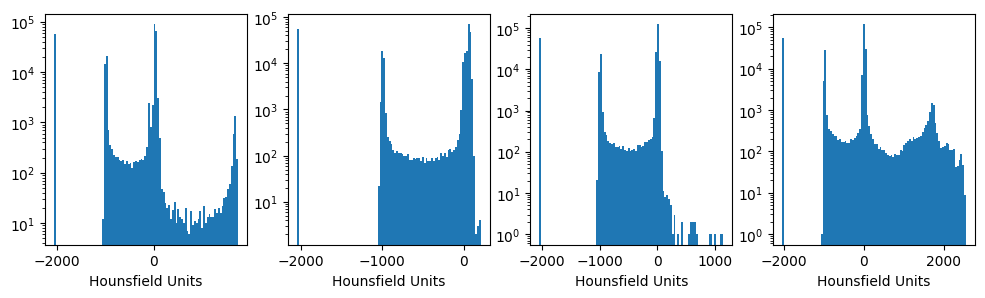

In [3]:
plt.subplots(1,4,figsize=(12,3))
plt.subplot(141)
plt.hist(IM1.pixel_array.ravel(), bins=100)
plt.semilogy()
plt.xlabel('Hounsfield Units')
plt.subplot(142)
plt.hist(IM2.pixel_array.ravel(), bins=100)
plt.semilogy()
plt.xlabel('Hounsfield Units')
plt.subplot(143)
plt.hist(IM3.pixel_array.ravel(), bins=100)
plt.semilogy()
plt.xlabel('Hounsfield Units')
plt.subplot(144)
plt.hist(IM4.pixel_array.ravel(), bins=100)
plt.semilogy()
plt.xlabel('Hounsfield Units')
plt.show()

* 0 HU's is water
* -1000 HU's is air
* 2000 HU's is metal

Get window centers and levels for plotting:

In [4]:
WL1 =58.5
WW1 = 181
WL2 = 82
WW2 = 96
WL3 = 233
WW3 = 3828
WL4 = 1463
WW4 = 1586

Plot all images

In [5]:
def save_im(img, name, bounds):
    img = np.clip(img,bounds[0],bounds[1])
    img-=np.min(img)
    img = img/np.max(img) * 256
    img = img.astype(np.uint8)
    im = Image.fromarray(img)
    im.save(name)

Save as png files, using the bounds

In [6]:
save_im(IM1.pixel_array, 'data/im1.png', (WL1-WW1/2, WL1+WW1/2))
save_im(IM2.pixel_array, 'data/im2.png', (WL2-WW2/2, WL2+WW2/2))
save_im(IM3.pixel_array, 'data/im3.png', (WL3-WW3/2, WL3+WW3/2))
save_im(IM4.pixel_array, 'data/im4.png', (WL4-WW4/2, WL4+WW4/2))

Plot the images

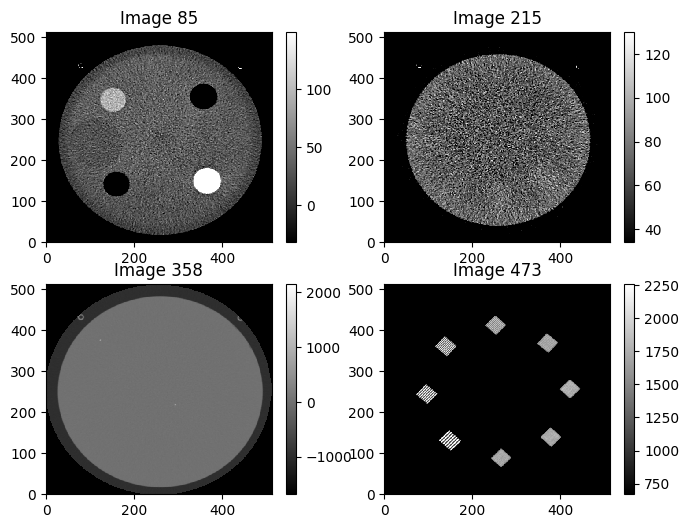

In [7]:
plt.subplots(2,2,figsize=(8,6))
plt.subplot(221)
plt.pcolor(IM1.pixel_array, vmin=WL1-WW1/2, vmax=WL1+WW1/2, cmap='gray')
plt.colorbar()
plt.title('Image 85')
plt.subplot(222)
plt.pcolor(IM2.pixel_array, vmin=WL2-WW2/2, vmax=WL2+WW2/2, cmap='gray')
plt.colorbar()
plt.title('Image 215')
plt.subplot(223)
plt.pcolor(IM3.pixel_array, vmin=WL3-WW3/2, vmax=WL3+WW3/2, cmap='gray')
plt.colorbar()
plt.title('Image 358')
plt.subplot(224)
plt.pcolor(IM4.pixel_array, vmin=WL4-WW4/2, vmax=WL4+WW4/2, cmap='gray')
plt.colorbar()
plt.title('Image 473')
plt.show()

## Part A

To get an estimate of the noise, we can use image 215

In [8]:
mask = IM2.pixel_array > WL2-WW2/2
sigma = np.std(IM2.pixel_array[mask])
mu = np.mean(IM2.pixel_array[mask])

Print values

In [9]:
print(f'Standard deviation: {sigma:.2f} HU')
print(f'Mean: {mu:.2f} HU')

Standard deviation: 14.54 HU
Mean: 69.19 HU


The noise (which is quantified by the standard deviation) is acceptable for clinical use so long as it doesn't hide prominent features to be detected. This largely depends on the specific clinical feature being studied. As seen in the other three image, the noise is not large enough to impact the visible features such as the disks ($\approx 0$HU) and the metal bars ($\approx 2000$HU).

## Part B

Open up masks that represent disks

In [10]:
disksmask = np.sum(imageio.imread('data/disksmask.png'), axis=-1)

Show masks where the disks are

* The central square is for computing the mean and standard deviation (noise) of the background

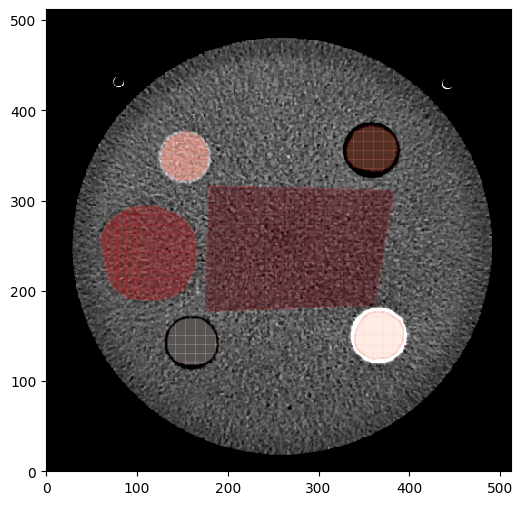

In [11]:
plt.figure(figsize=(6,6))
plt.pcolor(IM1.pixel_array, vmin=WL1-WW1/2, vmax=WL1+WW1/2, cmap='gray')
plt.pcolor(np.ma.masked_array(disksmask, disksmask <= 10), cmap='Reds', alpha=0.1)
plt.show()

We can get noise and mean estimates from each of these disk regions

In [12]:
disk1mask = (disksmask>200)*(disksmask<300)
disk2mask = (disksmask>300)*(disksmask<400)
disk3mask = (disksmask>400)*(disksmask<550)
disk4mask = (disksmask>550)*(disksmask<650)
disk5mask = (disksmask>700)*(disksmask<710)
centermask = (disksmask>750)
masks = [disk1mask, disk2mask, disk3mask, disk4mask, disk5mask]

Compute mean and standard deviation in each region

In [13]:
def get_mean_std(arr, mask):
    return np.mean(arr[mask]), np.std(arr[mask])
means, stds = np.array([get_mean_std(IM1.pixel_array, mask) for mask in masks]).T
mean_background, std_background = get_mean_std(IM1.pixel_array, centermask)

Compute CNR for each of the disks

$$CNR \equiv \frac{|\mu_i-\mu_b|}{\sigma_b}$$

where $\mu_i$ is the mean of region (disk) $i$ and $\mu_b$ and $\sigma_b$ are the mean and standard deviation of some background region.

In [14]:
CNRs = np.abs(means-mean_background)/std_background
[print(f'CNR = {CNR:.2f}') for CNR in CNRs];

CNR = 8.13
CNR = 100.78
CNR = 53.62
CNR = 4.91
CNR = 0.49


## Part C

Lets take a look at the image that contains the lines

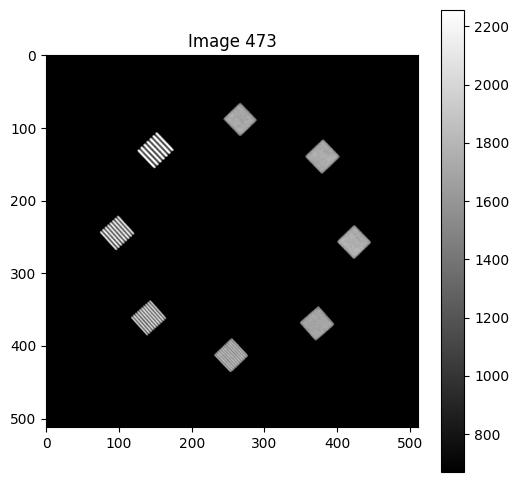

In [15]:
plt.figure(figsize=(6,6))
plt.imshow(IM4.pixel_array, vmin=WL4-WW4/2, vmax=WL4+WW4/2, cmap='gray')
plt.colorbar()
plt.title('Image 473')
plt.show()

The lines that show up most clear is the top left. This contains 7 lines, so it follows that the spcial resolution is $7~\text{lp/cm}$

## Part D

To determine the uniformity, we can examine a histogram of the center circle of Image 215Image 215.

In [16]:
mask = np.sum(imageio.imread('data/im2mask.png'), axis=-1)>0

Show plot

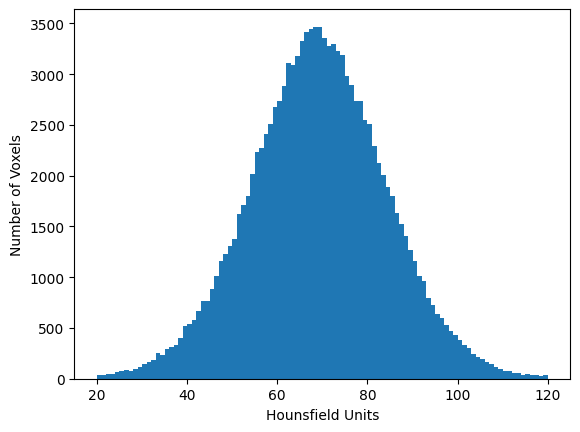

In [17]:
plt.hist(IM2.pixel_array[mask].ravel(), bins=100, range=(20, 120))
plt.xlabel('Hounsfield Units')
plt.ylabel('Number of Voxels')
plt.show()

This distribution is approximately Gaussian with a width of approximately 50HU. Since statistical noise is expected, this provides evidence that the material inside the phantom is uniform.

## Part E

Lets get a mask for the central water portion ($\approx 0$HU) in Image 358. It is assumed that this makes a perfect circle 

In [18]:
xv, yv = np.meshgrid(np.arange(512), np.arange(512))
mask_outside = np.sqrt((xv-512/2)**2 + (yv-512/2)**2) < 235
IM3mask = (IM3.pixel_array>-50)*(IM3.pixel_array<70)*mask_outside

Plot

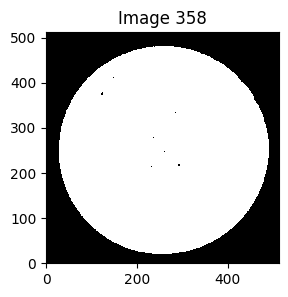

In [19]:
plt.figure(figsize=(3,3))
plt.pcolor(IM3mask, cmap='gray')
plt.title('Image 358')
plt.show()

What we will do is rotate this circle at a bunch of angles and compute the corresponding diameter. This will give an estimate of the relative geometric accuracy.

In [20]:
x = np.arange(0,IM3mask.shape[0],1)
y = np.arange(0,IM3mask.shape[1],1)

In [21]:
def compute_diameter(angle):
    im = rotate(IM3mask,angle=angle).astype(bool)
    x_in_circle = x[np.any(im, axis=0)]
    return x_in_circle[-1] - x_in_circle[0]

In [22]:
angles = np.linspace(0, 180, 180)
diameters = np.vectorize(compute_diameter)(angles)

Lets look at the relative uncertainty in these diameters

In [23]:
np.std(diameters)

1.1850925889754116

The standard deviation in the diameters is on the order of 1 pixel. As such, the geometric accuracy of the scanner is likely limited by the spatial resolution. This is fine, however, since the relative uncertainty is quite small:

In [24]:
unc = np.std(diameters)/np.mean(diameters) * 100
print(f'The relative uncertainty in the length of the diameter of the circle is {unc:.3f}%')

The relative uncertainty in the length of the diameter of the circle is 0.257%


The scanner is thus geometrically accurate within less than 1%.

# Question 2

**Method 1**: Compression of the breast results in a uniform thickness; this results in more uniform dose absorption throughout the tissue.

**Method 2**: The Heel Effect. By Tilting a tube (that has an intensity gradient) relative to the patient plane and aligning the patient so that the thicker region is in a more intense region of the beam, uniform dose absorption in the patient can be achieved.

**Method 3**: Automated exposure control can be used to get an lower limit on the amount of radiation exposure a patient is exposed to. By placing a detextor under the thickest part of the patient, a minimum threshhold can be established, and the X-ray tube can be automatically shut off. 

# Question 3

Fluroscopy involved repeated imaging to monitor temporal changes in various biophysical quantities, such as

* filling of blood vessels
* the insertion of a catheter
* placing a stent
* coiling an aneurysm

There are considerable risks involved in such a procedure. Since such procedures are often interventional and require staff, such as nurses, techs, and surgeons, radiation protective protocols is required for all involved. This involves lead shields during surgery, radiation protection for surgeons (such as lead aprons) and careful positioning of staff throughout the room during exposure periods. Since many images are acquired in such a procedure, high dosage is expected.

The benefits of fluoroscopy is that it provides information for surgeons during difficult surgical procedures. Such information may improve the success rates of the various procedures.

For the patient, due to the small probability of developing complications from the radiation, fluoroscopy is often preferred. Despite this, the ALARA principle is still applied (as low as reasonably achievable). In such a scenario, this implies that the surgeon/staff should use the imaging equipment as little as possible while still ensuring the maximum success for the surgery. While such a trade-off is very difficult to quantify, in reality, it means that the surgeon and staff should be discouraged from excessive use of the equipment.